# 目标检测数据集
目标检测领域没有像MNIST和Fashion-MNIST那样的小数据集。为了快速测试目标检测模型，[**我们收集并标记了一个小型数据集**]。首先，我们拍摄了一组香蕉的照片，并生成了1000张不同角度和大小的香蕉图像。然后，我们在一些背景图片的随机位置上放一张香蕉的图像。最后，我们在图片上为这些香蕉标记了边界框。

## 下载数据集
数据集下载地址：http://d2l-data.s3-accelerate.amazonaws.com/banana-detection.zip

下载完成后解压会得到两个文件夹，banana_train和banana_val，两个文件夹下面分别包含一个images文件夹（其中有1000张图片）和一个label.csv文件（记录了每张图片中边界框的位置）。

## 读取数据集
通过`read_data_bananas`函数，我们[**读取香蕉检测数据集**]。
该数据集包括一个的CSV文件，内含目标类别标签和位于左上角和右下角的真实边界框坐标。

In [1]:
import torch
import pandas as pd
import os
import torchvision

### read_data_bananas
函数返回的是images和labels，其中images是所有tensor类型的图像构成的列表，labels包含每个图像的标签（类别，x1, y1, x2, y2）的列表，两个列表的长度都是1000。

In [20]:
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = 'C:/Users/lenovo/pytorch-learning/data/banana-detection/'
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    # csv_data = pd.read_csv(csv_fname, index_col=0)
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'images',str(img_name))))
        
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256   

### BananasDatasets

通过使用`read_data_bananas`函数读取图像和标签，以下`BananasDataset`类别将允许我们[**创建一个自定义`Dataset`实例**]来加载香蕉检测数据集。

In [32]:
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if 
                                                is_train else f' validation examples'))
    
    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])
    
    def __len__(self):
        return len(self.features)

### Dataloader for BnanasDataset

最后，我们定义`load_data_bananas`函数，来[**为训练集和测试集返回两个数据加载器实例**]。对于测试集，无须按随机顺序读取它。

In [30]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

让我们读取一个小批量，并打印其中的图像和标签的形状。图像的小批量的形状为（批量大小，通道数，高度，宽度），标签的小批量的形状为（批量大小，m， 5），其中m是数据集的任何图像中边界框可能出现的最大数量。

小批量计算虽然高效，但它要求每张图像含有相同数量的边界框，以便放在同一个批量中。
通常来说，图像可能拥有不同数量个边界框；因此，在达到$m$之前，边界框少于$m$的图像将被非法边界框填充。
这样，每个边界框的标签将被长度为5的数组表示。
数组中的第一个元素是边界框中对象的类别，其中-1表示用于填充的非法边界框。
数组的其余四个元素是边界框左上角和右下角的（$x$，$y$）坐标值（值域在0到1之间）。
对于香蕉数据集而言，由于每张图像上只有一个边界框，因此$m=1$。

In [33]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape  # images， labels

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

## 演示数据集

In [39]:
def show_images(imgs, num_rows, num_cols, scale=1.5):
    _, axes = plt.subplots(num_rows, num_cols, 
                           figsize=(num_cols * scale, num_rows * scale))
    axes = axes.flatten()
    for i in range(len(imgs)):
        if torch.is_tensor(imgs[i]):
            axes[i].imshow(imgs[i].numpy())
        else:
            axes[i].imshow(imgs[i])
        axes[i].axes.get_xaxis().set_visible(False)
        axes[i].axes.get_yaxis().set_visible(False)
    return axes

In [43]:
def bbox_to_rect(bbox, color):
    return plt.Rectangle(
            xy=(bbox[0], bbox[1]),
            width=bbox[2] - bbox[0], height=bbox[3] - bbox[1],
            fill=False, edgecolor=color, linewidth=2)

选取10张图片进行展示：

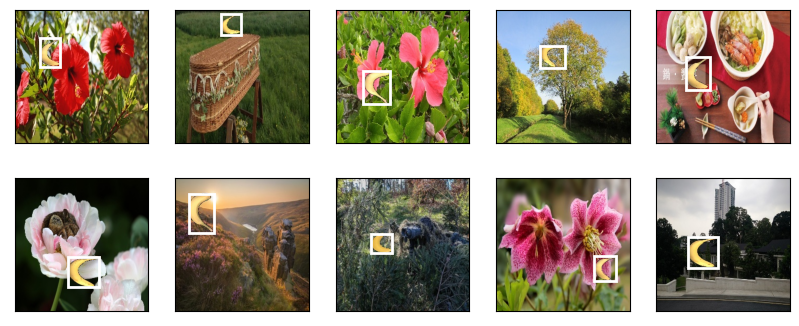

In [45]:
imgs = batch[0][0:10].permute(0, 2, 3, 1) / 255
axes = show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    ax.add_patch(bbox_to_rect(label[0][1:5] * 256, color='w'))